# Exercise 4 - Part A

### Necessary imports

In [514]:
from sentence_transformers import SentenceTransformer, util
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np
import random
from nltk import tokenize
import pandas as pd

### Data loading

In [608]:
sentences = []
with open("data/data2.txt", "r", encoding='utf8') as f:
    lines = f.read().replace("\n", " ")
    sentences = tokenize.sent_tokenize(lines)
    df = pd.DataFrame(sentences, columns=["sentence"])

### Obtaining the embeddings of the sentences

In [609]:
# Bert Embeddings for each sentence
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
bert_embeddings_definition = model.encode(sentences, convert_to_tensor=True)
df['embeddings'] = bert_embeddings_definition.tolist()

### Calculating the occurrence of each word in every sentence 

In [610]:
# Function for calculating three random numbers with a minimum spacing between them

def spreadRandom(theRange, howMany, minSpacing):
    while True:
        candidate = sorted([random.randint(*theRange) for _ in range(howMany)])
        minDiff = min([ candidate[i+1]-candidate[i] for i, _ in enumerate(candidate[:-1])])
        if minDiff >= minSpacing:
            return candidate

In [611]:
def calculate_cosine_similarity(blocks_index: list) -> list:
    blocks_similarity = []
    for i in range(len(blocks_index) + 1):
        if i == 0:
            blocks_similarity.append(util.torch.mean(util.cos_sim(df['embeddings'][0:blocks_index[0]].tolist(), df['embeddings'][0:blocks_index[0]].tolist())).item())
        elif i == len(blocks_index):
            blocks_similarity.append(util.torch.mean(util.cos_sim(df['embeddings'][blocks_index[i-1]:].tolist(), df['embeddings'][blocks_index[i-1]:].tolist())).item())
        else:
            blocks_similarity.append(util.torch.mean(util.cos_sim(df['embeddings'][blocks_index[i-1]:blocks_index[i]].tolist(), df['embeddings'][blocks_index[i-1]:blocks_index[i]].tolist())).item())

    return np.mean(blocks_similarity)

In [612]:
def calculate_cosine_similarity_between_blocks(blocks_index: list) -> list:
    blocks_embeddings = []
    for i in range(len(blocks_index) + 1):
        if i == 0:
            blocks_embeddings.append(np.mean(df['embeddings'][0:blocks_index[0]].tolist(), axis=0))
        elif i == len(blocks_index):
            blocks_embeddings.append(np.mean(df['embeddings'][blocks_index[i-1]:].tolist(), axis=0))
        else:
            blocks_embeddings.append(np.mean(df['embeddings'][blocks_index[i-1]:blocks_index[i]].tolist(), axis=0))
    final_blocks_embeddings = []
    for i in range(len(blocks_embeddings) - 1):
        final_blocks_embeddings.append(util.cos_sim(blocks_embeddings[i], blocks_embeddings[i+1]).item())

    return final_blocks_embeddings

In [613]:
# Calculating the similairty between each adjacent sentences
similarity = []
for index, sentence_embedding in enumerate(df['embeddings']):
    similarity.append(util.cos_sim(sentence_embedding, df['embeddings'][index + 1]).item() if index < len(df['embeddings']) - 1 else 0)
similarity = np.array(similarity)

In [618]:
# Finding the similarity that has a distance > 0.3 from the previous one
peaks = []
for index, simil in enumerate(similarity):
    if index > 1:
        if similarity[index - 2] - similarity[index - 1] > 0.2 and similarity[index] - similarity[index - 1] > 0.2:
            peaks.append(index)

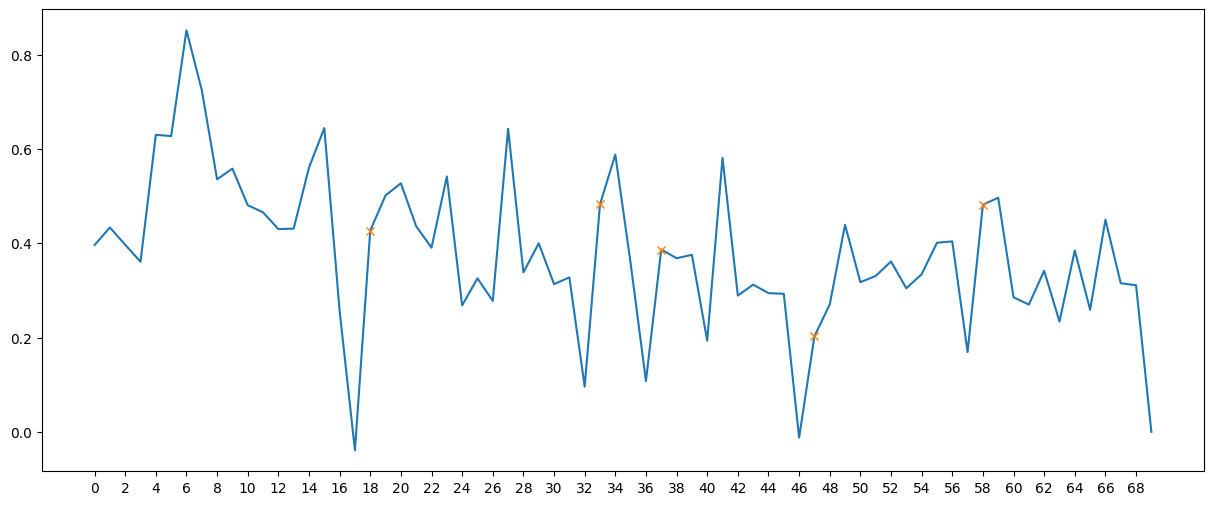

In [619]:
# Plotting the peaks on the similarity graph
plt.figure(figsize=(15,6))
plt.xticks(np.arange(0, len(sentences), 2))
plt.plot(similarity)
plt.plot(peaks, similarity[peaks], "x")
plt.show()

In [620]:
# Calculating the similarity of blocks changing the index blocks with the peaks found
blocks_similarity = {}
blocks_similarity_between = {}
for peak in peaks:
    for peak2 in peaks:
        if peak != peak2 and peak < peak2:
            blocks_index = [peak, peak2]
            blocks_similarity[str(peak) + "_" + str(peak2)] = calculate_cosine_similarity(blocks_index)
            blocks_similarity_between[str(peak) + "_" + str(peak2)] = calculate_cosine_similarity_between_blocks(blocks_index)

# Sorting blocks_similarity_between with the lowest similarity, but only who has 5 numbers of difference
blocks_index = {k: v for k, v in sorted(blocks_similarity_between.items(), key=lambda item: item[1][0] + item[1][1])}
blocks_index_similarity = {k: v for k, v in sorted(blocks_similarity.items(), key=lambda item: item[1])}

In [621]:
final_blocks_index = [int(index) for index in next(iter(blocks_index)).split("_")]
print("Final Blocks Index: ", final_blocks_index)
for i in range(len(final_blocks_index) + 1):
    print("Paragraph " + str(i+1) + ": ")
    if i == 0:
        for sentence in sentences[0:final_blocks_index[i]]:
            print(sentence)
    elif i == len(final_blocks_index):
        for sentence in sentences[final_blocks_index[i-1]:]:
            print(sentence)
    else:
        for sentence in sentences[final_blocks_index[i-1]:final_blocks_index[i]]:
            print(sentence)
    print("\n\n")

Final Blocks Index:  [18, 47]
Paragraph 1: 
Sanford Koufax (; born Sanford Braun; December 30, 1935) is an American former baseball pitcher who played 12 seasons in Major League Baseball (MLB) for the Brooklyn/Los Angeles Dodgers from 1955 to 1966.
He has been hailed as one of the greatest pitchers in baseball history.
After joining the major leagues at age 19, having never pitched a game in the minor leagues, the first half of his career was marred with inconsistency and control problems, as he posted a win–loss record of 36–40 with a 4.10 earned run average.
He was a member of World Series championship teams in both Brooklyn and Los Angeles, though he did not appear in any of the Series wins despite pitching brilliantly in the 1959 series.
After making adjustments prior to the 1961 season to improve his control and getting more regular playing time, Koufax quickly rose to become the most dominant pitcher in MLB before arthritis in his left elbow ended his career prematurely at age 30